In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

#### Exploring Rossmann Drug Store Sales Data

In [2]:
DataStore = pd.read_csv("https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/rossmann.csv",low_memory=False)

In [3]:
DataStore.head(4)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1


Because we are most interested in the Date column that contains the date of sales for each store, we will make sure to process that as a DateTime type, and make that the index of our dataframe.


In [4]:
DataStore['Date'] = pd.to_datetime(DataStore['Date'])
DataStore.set_index('Date', inplace=True)
DataStore['Year'] = DataStore.index.year  #If you want to acces Year later or Acces Month later
DataStore['Month'] = DataStore.index.month
DataStore.head(4)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7


In [5]:
DataStore.sort_index(axis = 0,ascending = True,inplace = True)
store1_data = DataStore[DataStore.Store == 1]
store1_data.head(4)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2013,1
2013-01-02,1,3,5530,668,1,0,0,1,2013,1
2013-01-03,1,4,4327,578,1,0,0,1,2013,1
2013-01-04,1,5,4486,619,1,0,0,1,2013,1


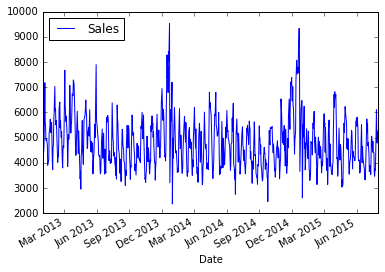

In [6]:
# Filter to days store 1 was open
store1_open_data = store1_data[(store1_data.Open==1)]
store1_open_data[['Sales']].plot()

#### AutoCorrelation Models

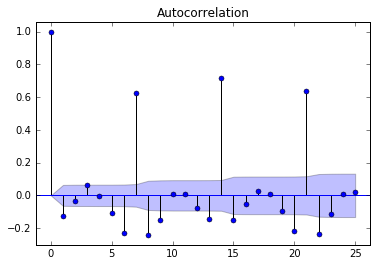

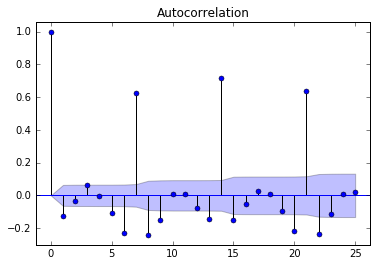

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=25)


Here we observe autocorrelation at 25 lag values.   This implies a small, but limited impact based on the last few values, suggesting that an autoregressive model might be useful.

We also observe a larger spike at 7 - what does that mean?

That's the amount of days in a week!

If we observed a handful of randomly distributed spikes - that would imply a MA model may be useful. This is because those random spikes suggest that at some point in time, something changed in the world and all values are shifted up down from there in a fixed way.

# ARMA

To explore AR and ARMA models, we will use sm.tsa.ARMA. Remember, an ARMA model is a combination of autoregressive and moving average models.

We can train an autoregressive model by turning off the moving average component (setting q = 0).



In [9]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (5, 0)).fit() # p=5, q=0
model.summary() #Hierarchy exists, cannot keep lag 3 without keeping lag 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(5, 0)   Log Likelihood               -6234.994
Method:                       css-mle   S.D. of innovations            708.940
Date:                Mon, 21 Mar 2016   AIC                          12483.987
Time:                        20:46:17   BIC                          12516.611
Sample:                    01-02-2013   HQIC                         12496.534
                         - 07-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4758.9840     65.452     72.710      0.000      4630.701  4887.267
ar.L1.Sales     0.7020      0.035     20.173      0.000         0.634     0.770
ar.L2.Sales     0.0568      0.042      1.354      0.176        -0.025     0.139
ar.L3.Sales    -0.1711      0.042     -4.117      0.000        -0.252    -0.090
ar.L4.Sales     0.2581      0.042      6.150      0.000         0.176     0.340
ar.L5.Sales    -0.2331      0.035     -6.661      0.000        -0.302    -0.165
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2714           -0.0000j            1.2714           -0.5000
AR.2            1.1791           -0.4519j            1.2628           -0.0582
AR.3            1.1791           +0.4519j            1.2628            0.0582
AR.4            0.0101           -1.4545j            1.4545           -0.2489
AR.5            0.0101           +1.4545j            1.4545            0.2489
-----------------------------------------------------------------------------
"""

# Residual Plot

Residuals are the errors of the model, or a measure of how off our prior predictions were.

What we ideally want are randomly distributed errors that are fairly small. If the errors are large then clearly that would be problematic. If the errors have a pattern, particularly over time, then we have overlooked something in the model or certain periods of time are different than the rest of the dataset.

We can plot the residuals as below:



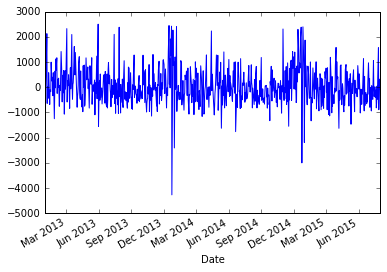

In [10]:
model.resid.plot()

Here we saw large spikes at the end of each year, indicating that our model does not account for holiday spikes. Of course, our models are only related to the last few values in the time series, and don't take into account the longer seasonal pattern.



# ARIMA Model

To train an ARIMA model in statsmodels, we can change the ARMA model to ARIMA and additionally provide the differencing parameter. To start, we can see that we can train an ARMA(2,2) model by training an ARIMA(2, 0, 2) model.

We can see that this model in fact simplifies automatically to an ARMA model. If we change the differencing parameter to 1, we train an ARIMA(7, 1, 2). This predicts the difference of the series.



In [11]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -6221.636
Method:                       css-mle   S.D. of innovations            703.783
Date:                Mon, 21 Mar 2016   AIC                          12465.272
Time:                        20:49:14   BIC                          12516.524
Sample:                    01-03-2013   HQIC                         12484.984
                         - 07-31-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            -0.6869      4.555     -0.151      0.880        -9.614     8.240
ar.L1.D.Sales     0.8404      0.211      3.982      0.000         0.427     1.254
ar.L2.D.Sales    -0.1503      0.145     -1.038      0.300        -0.434     0.134
ar.L3.D.Sales    -0.1831      0.046     -3.976      0.000        -0.273    -0.093
ar.L4.D.Sales     0.2557      0.060      4.296      0.000         0.139     0.372
ar.L5.D.Sales    -0.3381      0.067     -5.018      0.000        -0.470    -0.206
ar.L6.D.Sales     0.0691      0.074      0.931      0.352        -0.076     0.215
ar.L7.D.Sales    -0.0656      0.050     -1.325      0.185        -0.163     0.031
ma.L1.D.Sales    -1.1350      0.209     -5.443      0.000        -1.544    -0.726
ma.L2.D.Sales     0.2373      0.197      1.203      0.229        -0.149     0.624
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2128           -0.0000j            1.2128           -0.5000
AR.2            1.0141           -0.4950j            1.1285           -0.0723
AR.3            1.0141           +0.4950j            1.1285            0.0723
AR.4           -0.1357           -1.7545j            1.7597           -0.2623
AR.5           -0.1357           +1.7545j            1.7597            0.2623
AR.6            0.2547           -1.7665j            1.7848           -0.2272
AR.7            0.2547           +1.7665j            1.7848            0.2272
MA.1            1.1647           +0.0000j            1.1647            0.0000
MA.2            3.6180           +0.0000j            3.6180            0.0000
-----------------------------------------------------------------------------
"""

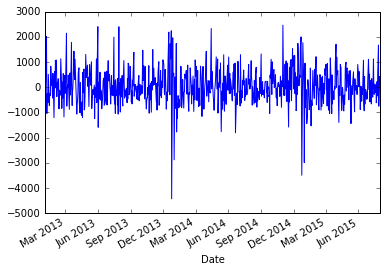

In [12]:
model.resid.plot()


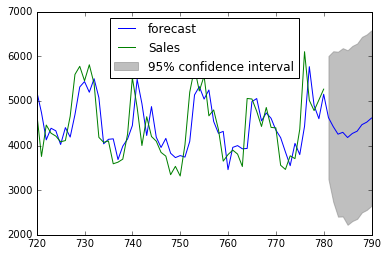

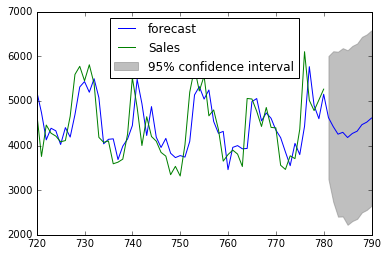

In [14]:
model.plot_predict(720,790) #Data only goes to 780, so 780 to 790 is extrapolated 

In [15]:
print model.predict(770,790)

770    -58.739067
771   -217.854928
772    298.920755
773     84.276925
774    279.225126
775     89.768630
776     67.610387
777   -335.493293
778   -115.974407
779   -181.162465
780    128.753250
781   -637.256121
782   -201.626244
783   -169.737428
784     41.360806
785   -116.834479
786     91.370522
787     51.157723
788    146.111163
789     55.624453
790     91.894481
dtype: float64


/Users/benstan/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


# Now let's change our data to weekly data

In [16]:
store1_sales_weekly = DataStore[DataStore.Store == 1][['Sales']].resample('W', 'sum').astype(float) #W for week, M for Month, D for day

In [17]:
store1_sales_weekly.head()

,Sales
Date,
2013-01-06,19340
2013-01-13,32952
2013-01-20,25978
2013-01-27,33071
2013-02-03,28693


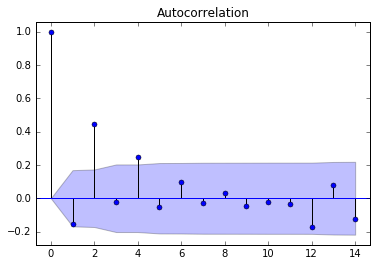

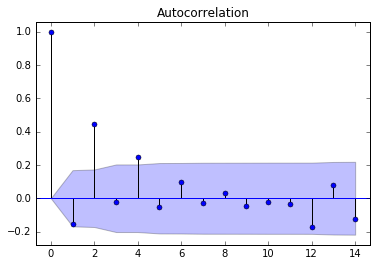

In [18]:
plot_acf(store1_sales_weekly.Sales, lags=14)

This is so much better than daily data!

### Now let's divide our dataset to train and test. We can only do so in a sequential manner
### This is an example of how NOT to process this data

In [19]:
n = len(store1_sales_weekly.Sales)
train = store1_sales_weekly.Sales[:int(.75*n)] #first 75% of data assigned to training set
test = store1_sales_weekly.Sales[int(.75*n):]  #last 25% of data assigned to our test set

In [20]:
print test.index[0]
print test.index[len(test)-1]

2014-12-14 00:00:00
2015-08-02 00:00:00


In [21]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, (2, 0, 0)).fit()
model.summary()
predictions = model.predict(start = '2014-12-14',end = '2015-08-02')

#predictions = model.predict(start = '2014-12-14',end = '2015-08-02',dynamic = False, typ ='levels')
# if you set ARIMA(p,d > 0,q) then you cannot measure test error this way 
from sklearn.metrics import mean_absolute_error
SE = (mean_absolute_error((test), predictions))**.5   
print SE

57.7785768941


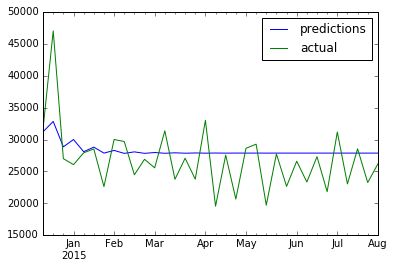

In [22]:
DataFramePredictions = pd.DataFrame(predictions)
DataFramePredictions['Actual'] = test
DataFramePredictions.columns = ['predictions','actual']
DataFramePredictions.plot()

# A better way to deal with Train/Test data

/Users/benstan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/benstan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/benstan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/benstan/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2928.63338929


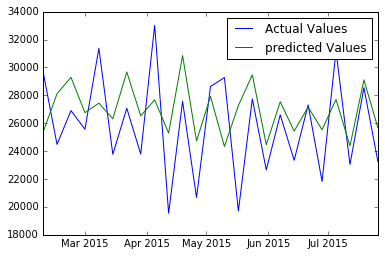

In [23]:
# Let's test our model on last 20% of data
p = 3
d = 0
q = 1
TestRatio = 0.20
pred = []
indexData = []
ActualObservations = []
n = len(store1_sales_weekly.Sales)
for i in range(1,int(TestRatio*n-1)):
    train = store1_sales_weekly.Sales[:(int((1-TestRatio)*n+i))]
    #print train.tail(1)
    test = store1_sales_weekly.Sales[(int((1-TestRatio)*n+i)):]
    #print test
    #print train
    model = ARIMA(train,(p, d, q)).fit()
    predictions = model.predict(start = str(test.index.date[0]), end= str(test.index.date[0])) 
    #if d > 0 you must set  
    # model.predict(start = str(test.index.date[0]), end= str(test.index.date[0]),dynamic = False, typ ='levels')
    pred.append(predictions[0])
    indexData.append(test.index.date[0])
    ActualObservations.append(store1_sales_weekly.Sales[test.index.date[0]])
    #print predictions

PredictActualDataFrame = pd.DataFrame({'predicted Values':pred,
                                       'Actual Values':ActualObservations,
                                       },index = indexData)
PredictActualDataFrame.plot()

MAD = (mean_absolute_error(pred, ActualObservations)) 
print MAD